Let's make an airfoil.

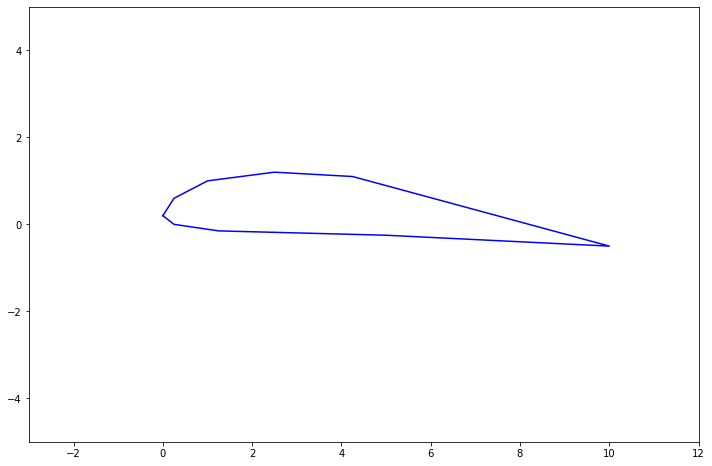

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

points = np.array([
    [0.0, 0.02],
    [0.025, 0.06],
    [0.1, 0.1],
    [0.25, 0.12],
    [0.425, 0.11],
    [1.0, -0.05],
    [0.5, -0.025],
    [0.125, -0.015],
    [0.025, 0.0],
    [0.0, 0.02]
]) * 10

def init_plot():
    fig = plt.figure(figsize=(12, 8))
    plt.xlim((-3, 12))
    plt.ylim((-5, 5))
    return fig

def draw_foil(fig, points):
    x = points[:, 0]
    y = points[:, 1]    
    plt.plot(x, y, 'b-', scalex=False, scaley=False)

fig = init_plot()
draw_foil(fig, points)
plt.show()

(Imagine it is sitting suspended in air on a windless day.

"Pressure" is a force distributed uniformly over an area.  At least, that's my understanding of it.  An object in a volume of gas feels pressure from that gas.  We represent that pressure as a force acting normal to the object's surface at every point, or "patch", on that object.

The pressure is thought of as the net result of the solid bits - the molecules - in the gas colliding with the surface.  No matter the angle of any individual collision on a surface patch of the object, the net effect can be represented by a force acting normal to the patch.

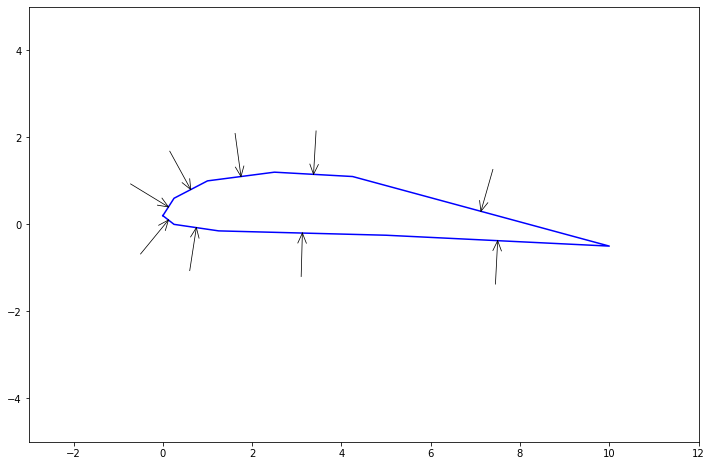

In [128]:
import math

segments = [points[i - 1: i + 1] for i in range(1, len(points))]

def gen_normals(segments):
    for p0, pf in segments:
        dx = pf[0] - p0[0]
        dy = pf[1] - p0[1]
        angle = math.atan2(dy, dx)
        normal_angle = angle + np.pi / 2.0
        nx = math.cos(normal_angle)
        ny = math.sin(normal_angle)
        # Represent each normal by the mid-point of the segment
        # from which it is derived, and its x and y component.
        xmid = (p0[0] + pf[0]) / 2.0
        ymid = (p0[1] + pf[1]) / 2.0
        result = [xmid, ymid, nx, ny]
        yield result

normals = np.array(list(gen_normals(segments)))

def draw_arrow(fig, normal, style="k-", linewidth=0.75):
    x, y, dx, dy = normal
    x0 = x + dx
    y0 = y + dy
    plt.plot([x, x0], [y, y0], style, linewidth=linewidth)
    angle = math.atan2(dy, dx)
    a1 = angle + math.pi / 8.0
    a2 = angle - math.pi / 8.0
    head_len = 0.25
    for a in [a1, a2]:
        adx = head_len * math.cos(a)
        ady = head_len * math.sin(a)
        plt.plot([x, x + adx], [y, y + ady], style, linewidth=linewidth)
    
def draw_normals(fig, normals, style="k-"):
    for norm in normals:
        draw_arrow(fig, norm, style)

fig = init_plot()
draw_foil(fig, points)
draw_normals(fig, normals)
plt.show()

Here's the airfoil again, with a few normal vectors added.  Each of these vectors represents the pressure at that patch of the airfoil.  You could think of each of these vectors as representing the path that a representative molecule traverses, during some time interval $\Delta{t}$, in order to generate the gas pressure on a patch of the airfoil.

Let's sum up all of these fractional pressures to get a net force of these representative molecules on the airfoil.

[-1.0824674490095276e-15, 4.440892098500626e-16]


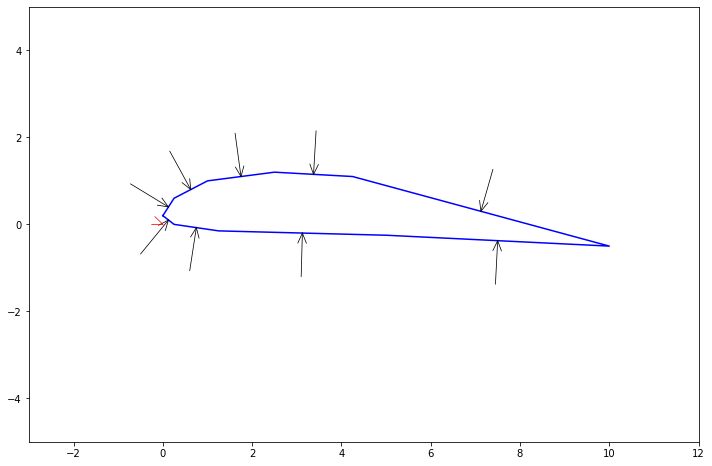

In [129]:
# Are you thinking, "This would have been much more readable
# if you'd defined a couple of appropriate classes?"
# I know I am.

def segment_length(p0, pf):
    dx = pf[0] - p0[0]
    dy = pf[1] - p0[1]
    return math.sqrt(dx * dx + dy * dy)

# A normal represents a pressure: force / unit area.
# In this 2D illustruction, the analog is force / unit length.  So the
# total force for each normal is normal * segment length.
def normal_force(p0, pf, normal):
    seg_length = segment_length(p0, pf)
    x, y, dx, dy = normal
    force_dx = dx * seg_length
    force_dy = dy * seg_length
    return [force_dx, force_dy]

def sum_forces(points, normals):
    result_x = 0.0
    result_y = 0.0
    for i in range(len(normals)):
        p0 = points[i]
        pf = points[i + 1]
        normal = normals[i]
        force_dx, force_dy = normal_force(p0, pf, normal)
        result_x += force_dx
        result_y += force_dy
    return [result_x, result_y]

total_force = sum_forces(points, normals)
print(total_force)

def plot_force_vec(fig, fv):
    # Oops!  I should have computed the origin of the total
    # force vector...
    anchored = np.array([0.0, 0.0] + list(fv))
    draw_arrow(fig, anchored, style="r-")
    
fig = init_plot()
draw_foil(fig, points)
draw_normals(fig, normals)
plot_force_vec(fig, total_force)
plt.show()


(TBH I didn't expect the net force to sum to zero.  It's easy to imagine a shape with bottom surface so crinkly that it is signifcantly "longer" than the top surface; and to guess that the net effect would be an upward pressure.  But maybe testing would show the crinkles have such small individual extent that their summed horizontal extent is no greater than that of an upper surface?  But I digress...)

Now let's add a little wind.  Adding the same wind vector to each representative normal vector gives a new path that each representative molecule travels before colliding with the airfoil.

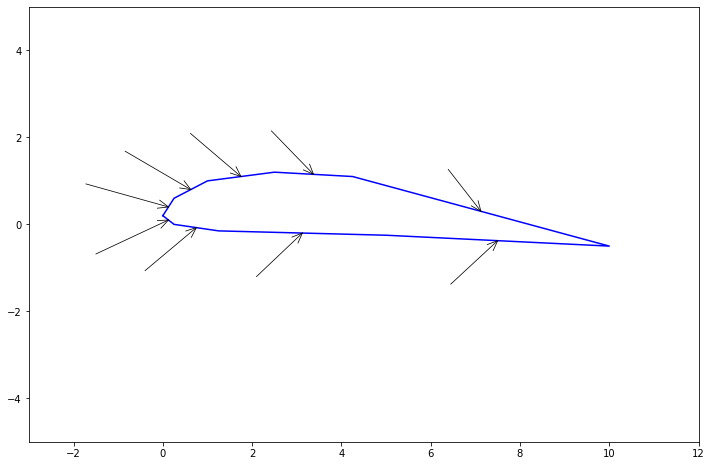

array([[ 0.125     ,  0.4       , -1.8479983 ,  0.52999894],
       [ 0.625     ,  0.8       , -1.47058824,  0.88235294],
       [ 1.75      ,  1.1       , -1.13216372,  0.9912279 ],
       [ 3.375     ,  1.15      , -0.94295021,  0.99837133],
       [ 7.125     ,  0.3       , -0.73192409,  0.96339779],
       [ 7.5       , -0.375     , -1.04993762, -0.99875234],
       [ 3.125     , -0.2       , -1.02665719, -0.99964463],
       [ 0.75      , -0.075     , -1.14834045, -0.98893635],
       [ 0.125     ,  0.1       , -1.62469505, -0.78086881]])

In [130]:
def with_wind(normals):
    wind = [-1.0, 0.0]
    result = []
    for x, y, dx, dy in normals:
        dx += wind[0]
        dy += wind[1]
        result.append(np.array([x, y, dx, dy]))
    return np.array(result)

wind_vectors = with_wind(normals)

fig = init_plot()
draw_foil(fig, points)
draw_normals(fig, wind_vectors)
plt.show()

wind_vectors

What component of each of these vectors is normal to its surface patch?

In [145]:
# Compute the component of each windy normal that lies along the normal --
# wind_vectors[i] • normals[i].

def dot(v0, v1):
    return v0[0] * v1[0] + v0[1] * v1[1]

def project(v0, v1):
    """Get the projection of v0 onto v1.  I think."""
    dot_prod = dot(v0, v1)
    return dot_prod * v1

def magnitude(v):
    return math.sqrt(sum(c * c for c in v))

def normal_dot(normal, v):
    """
    Project a unit vector (normal) onto another vector (v).
    Returns 
    """
    # Normal contains [x, y, dx, dy]
    origin = normal[:2]
    vnormal = normal[2:]
    v = project(v, vnormal)
    return np.array(list(origin) + list(v))

windy_normals = [normal_dot(n, wv) for (n, wv) in zip(normals, windy_vectors)]
print("Normal vectors:", normals)
print("Wind vectors:", windy_vectors)
print("Normal components of wind vectors:", windy_normals)
windy_normals

Normal vectors: [[ 0.125       0.4        -0.8479983   0.52999894]
 [ 0.625       0.8        -0.47058824  0.88235294]
 [ 1.75        1.1        -0.13216372  0.9912279 ]
 [ 3.375       1.15        0.05704979  0.99837133]
 [ 7.125       0.3         0.26807591  0.96339779]
 [ 7.5        -0.375      -0.04993762 -0.99875234]
 [ 3.125      -0.2        -0.02665719 -0.99964463]
 [ 0.75       -0.075      -0.14834045 -0.98893635]
 [ 0.125       0.1        -0.62469505 -0.78086881]]
Wind vectors: [[ 0.125       0.4        -5.8479983   0.52999894]
 [ 0.625       0.8        -5.47058824  0.88235294]
 [ 1.75        1.1        -5.13216372  0.9912279 ]
 [ 3.375       1.15       -4.94295021  0.99837133]
 [ 7.125       0.3        -4.73192409  0.96339779]
 [ 7.5        -0.375      -5.04993762 -0.99875234]
 [ 3.125      -0.2        -5.02665719 -0.99964463]
 [ 0.75       -0.075      -5.14834045 -0.98893635]
 [ 0.125       0.1        -5.62469505 -0.78086881]]
Normal components of wind vectors: [array([ 0.125 

[array([ 0.125     ,  0.4       , -0.08988764,  0.05617978]),
 array([ 0.625     ,  0.8       , -0.19377163,  0.3633218 ]),
 array([ 1.75      ,  1.1       , -0.11353712,  0.85152838]),
 array([3.375     , 1.15      , 0.07648495, 1.33848657]),
 array([7.125     , 0.3       , 0.58951505, 2.11856972]),
 array([ 7.50000000e+00, -3.75000000e-01, -3.04930407e-17, -6.09860813e-16]),
 array([ 3.12500000e+00, -2.00000000e-01, -3.10890034e-03, -1.16583763e-01]),
 array([ 0.75      , -0.075     ,  0.00550122,  0.03667482]),
 array([0.125     , 0.1       , 0.09756098, 0.12195122])]

In [151]:
# Test dot product and projection.
v1 = np.array([1.0, 0.0])
v2 = np.array([0.0, 1.0])
v3 = np.array([0.707, 0.707])

assert dot(v1, v2) == 0.0
assert dot(v1, v3) == 0.707
assert dot(v2, v3) == 0.707

v1 = np.array([2.0, 0.0])
v2 = np.array([0.0, 3.0])
sqrt2_inv = 1.0 / math.sqrt(2.0)
v3 = 7.0 * np.array([sqrt2_inv, sqrt2_inv])
u1 = np.array([sqrt2_inv, sqrt2_inv])

assert dot(v1, v3) == 14.0 * sqrt2_inv
proj = project(v1, u1)
print(magnitude(u1))
assert abs(magnitude(u1) - 1.0) <= 1.0e-6
print("Magnitude of projection:", magnitude(proj))


0.9999999999999999
Magnitude of projection: 1.4142135623730947


[3.2987796605533513, 16.253472443917946]


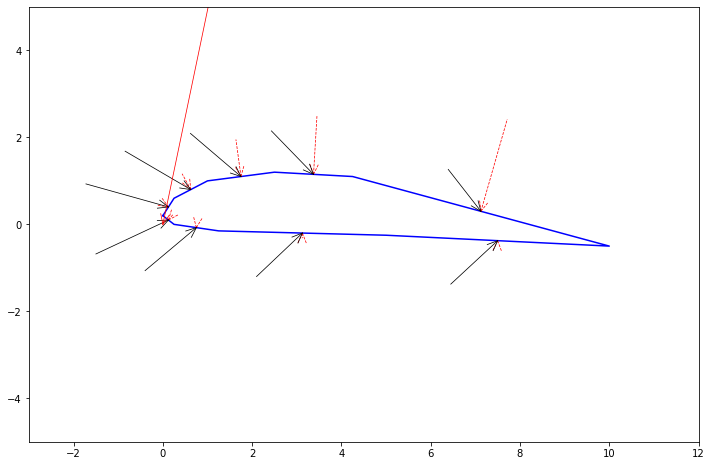

In [153]:
total_windy_force = sum_forces(points, windy_normals)
print(total_windy_force)

fig = init_plot()
draw_foil(fig, points)
draw_normals(fig, windy_normals, style="r--")
draw_normals(fig, wind_vectors)
plot_force_vec(fig, total_windy_force)
plt.show()



(Fig 5)

That's pretty interesting!  By adding a bit of wind we can change the pressure over different parts of the airfoil.  The top of the airfoil feels less pressure than the bottom.

The net force changes, too.  We have lift.

Is this guaranteed?  Of course not.  The lift force on an airfoil in a flowing gas varies depending on the angle of attack - the angle of the flow with respect to, say, the chord line of the airfoil.

(Fig 6)

I'm pretty sure every airfoil has an angle of attack at which the net lifting force is zero.  This is the angle of zero lift.

We've all been fed this line about air traveling farther over the top of a wing, the Bernoulli effect, etc.  I think it's a lousy explanation.  Read yer [Langeweische](https://en.wikipedia.org/wiki/Stick_and_Rudder)!  That's Wolfgang Langeweische, and "Stick and Rudder."  Chapter 1 explains clearly, without any math, how a wing makes lift.

The air flowing over the top of a wing is under no obligation to reach the trailing edge simultaneously with the air flowing under the bottom of the wing.  The University of Iowa provides [experimental evidence](https://youtu.be/-GIToNj-m4M?t=321).